In [79]:
import numpy as np
import pandas as pd
from functools import reduce
import itertools
import math
import time

import json #for input reading
from datetime import datetime, timedelta #for working with dates
from fastdtw import fastdtw #Dynamic time warping implementation
from sklearn.model_selection import KFold #K fold validation

from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.cross_decomposition import PLSRegression #Partial least squares

In [89]:
#plotting funcitons
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20

pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

# Data Pre-processing

## Read data file

In [81]:
#Loading json data from file
with open('new_data.json') as f:
    data = json.load(f)

#Converting json into DataFrame
hand_gesture_raw = pd.DataFrame(data)

temp_hand_gesture_data = []

#Traversing through data to add the action_no
for i in range(len(hand_gesture_raw.index)):
     series = pd.DataFrame(hand_gesture_raw['data'][i])
     #Adding Column action_no to differentiate the actions
     series['action_no'] = i
     series['gesture'] = hand_gesture_raw.loc[i,'gesture']
     #series = make_time_relative(series)
     temp_hand_gesture_data.append(series)
  
#Finally merging the data into one dataframe        
hand_gesture_data = reduce(lambda x, y: pd.merge(x, y, how ='outer'), temp_hand_gesture_data)
hand_gesture_data.drop(labels = ['__v', '_id'], inplace = True, axis = 1)
hand_gesture_data

,data,device_address,timestamp,action_no,gesture
0,!358$,00:0E:0E:15:44:3A,2018-12-14T12:49:55.112Z,0,handshake
1,!642$,00:0E:0E:0D:77:9D,2018-12-14T12:49:55.164Z,0,handshake
2,!642$,00:0E:0E:0D:77:9D,2018-12-14T12:49:55.064Z,0,handshake
3,!358$,00:0E:0E:15:44:3A,2018-12-14T12:49:55.175Z,0,handshake
4,!358$,00:0E:0E:15:44:3A,2018-12-14T12:49:55.496Z,0,handshake
5,!622$,00:0E:0E:0D:7B:0A,2018-12-14T12:49:55.506Z,0,handshake
6,!834$,00:0E:0E:0D:7B:01,2018-12-14T12:49:55.238Z,0,handshake
7,!642$,00:0E:0E:0D:77:9D,2018-12-14T12:49:55.232Z,0,handshake
8,!533$,00:0E:0E:0D:7A:E0,2018-12-14T12:49:55.245Z,0,handshake
9,!533$,00:0E:0E:0D:7A:E0,2018-12-14T12:49:55.315Z,0,handshake


## Read device file

In [82]:
with open('devices.txt') as f:
    data = json.load(f)

#Converting json into DataFrame
devices = pd.DataFrame(data)
devices

,device_address,finger
0,00:0E:0E:15:44:3A,thumb
1,00:0E:0E:0D:7A:E0,index finger
2,00:0E:0E:0D:7B:0A,middle finger
3,00:0E:0E:0D:77:9D,ring finger
4,00:0E:0E:0D:7B:01,pinky


## Merging data and parsing the device_data rows

In [83]:
device_data = hand_gesture_data.merge(devices, on = 'device_address')


#Parsing data into individual columns
device_data['timestamp'] = device_data['timestamp'].astype('datetime64[ms]')
device_data['roll'] = device_data['data'].str[1].astype(int)
device_data['pitch'] = device_data['data'].str[2].astype(int)
device_data['yaw'] = device_data['data'].str[3]

#some values incorrectly appear as negative, we replace them with 0-s 
device_data['yaw'] = device_data['yaw'].replace('-', '0')
device_data['yaw'] = device_data['yaw'].astype(int)

device_data.drop(labels = ['device_address', 'data'], inplace = True, axis = 1)
device_data

,timestamp,action_no,gesture,finger,roll,pitch,yaw
0,2018-12-14 12:49:55.112,0,handshake,thumb,3,5,8
1,2018-12-14 12:49:55.175,0,handshake,thumb,3,5,8
2,2018-12-14 12:49:55.496,0,handshake,thumb,3,5,8
3,2018-12-14 12:49:55.561,0,handshake,thumb,3,5,8
4,2018-12-14 12:49:55.436,0,handshake,thumb,3,5,8
5,2018-12-14 12:49:55.443,0,handshake,thumb,3,5,8
6,2018-12-14 12:49:55.777,0,handshake,thumb,3,5,8
7,2018-12-14 12:49:55.838,0,handshake,thumb,3,5,8
8,2018-12-14 12:49:55.893,0,handshake,thumb,3,4,8
9,2018-12-14 12:49:55.967,0,handshake,thumb,3,4,8


## Convert DataFrame to Array and Sample Data at 100ms Intervals

In [84]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

samples = []
labels = []

grouped_df = device_data.groupby(by=['action_no'])
for g_name, group in grouped_df:
    labels.append(group['gesture'].iloc[0]) #add label to label array
    
    start = group['timestamp'].min() #find the earliest measurement for action_no group
    pd.options.mode.chained_assignment = None  # Override false positive warning on immediate next line
    group['timestamp'] = group['timestamp'] - start #find delta time for all timestamps
    
    #Find the 'earliest' latest measurement with the 5 fingers
    group = group.sort_values('finger') #Order matters; fingers must appear in alphabetical order
    fgrouped_df = group.groupby(by=['finger'])
    max_iterations = int(fgrouped_df['timestamp'].max().min() / np.timedelta64(100,'ms'))
    
    group_data_formated = np.zeros(shape=(max_iterations+1, 15))
    
    finger_idx = 0
    for fg_name, fgroup in fgrouped_df:
        fgroup = fgroup.sort_values('timestamp')
        for time_idx in range(max_iterations+1):
            nearest_index = find_nearest(fgroup['timestamp'].values, time_idx*100000000)
            group_data_formated[time_idx,finger_idx] = fgroup['roll'].values[nearest_index]
            group_data_formated[time_idx,finger_idx+5] = fgroup['pitch'].values[nearest_index]
            group_data_formated[time_idx,finger_idx+10] = fgroup['yaw'].values[nearest_index]
            
            #Data Array Format
            #Index: [0     1     2     3     4     5     6 ....    14]
            #Data:[i-r    m-r   p-r  r-r    t-r   i-p   m-p ....  r-y]
            #first letter represents index, middle, pinky, ring, thumb
            #second letter represents roll, pitch, yaw
                        
        finger_idx += 1

    samples.append(group_data_formated) #add fully populated data array to list

labels = np.array(labels)
samples = np.array(samples)
labels, samples

(array(['handshake', 'handshake', 'handshake', 'handshake', 'handshake',
        'handshake', 'handshake', 'handshake', 'handshake', 'handshake',
        'handshake', 'handshake', 'handshake', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'hello',
        'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello',
        'hello', 'hello', 'hello'], dtype='<U9'),
 array([array([[5., 6., 8., 6., 3., 3., 2., 3., 4., 5., 3., 2., 4., 2., 8.],
        [5., 6., 8., 6., 3., 3., 2., 3., 4., 5., 3., 2., 4., 2., 8.],
        [5., 6., 8., 6., 3., 3., 2., 3., 4., 5., 3., 2., 4., 2., 8.],
        [4., 6., 8., 6., 3., 3., 2., 3., 4., 5., 3., 2., 4., 2., 8.],
        [4., 6., 8., 6., 3., 3., 2., 3., 3., 5., 3., 2., 4., 2., 8.],
        [4., 6., 8., 6., 3., 3., 2., 3., 4., 5., 3., 2., 4., 2., 8.],
        [4., 5., 8., 6., 3., 3., 2., 4., 4., 5., 3., 2., 4., 2., 8.],
        [5., 5., 8., 

## Performance metrics reused from Assignment 1:

In [57]:
def accuracy(df, correctlabels):
    maxvals = df.idxmax(axis=1).values
    match_count = 0
    for idx, label in enumerate(correctlabels):
        if maxvals[idx] == label:
            match_count += 1
    return match_count/len(maxvals)

def brier_score(df, correctlabels):
    pred_errors = []
    column_count =len(df.columns)
    for ind, l in enumerate(correctlabels):
        real_probs = np.zeros(column_count)
        correct_ind = np.where(df.columns == l)[0] 
        real_probs[correct_ind] = 1.0
        pred_errors.append(np.sum(pow(df.iloc[ind] - real_probs, 2)))
    return np.average(pred_errors)

## K-NN classifier based on the solution for task 1:

In [58]:
def euclidean_distance(train_sample, test_sample):
    squaredistance = np.sum((train_sample-test_sample)**2)
    return np.sqrt(squaredistance)

def dtw_distance(train_sample, test_sample):
    dist, path = fastdtw(train_sample, test_sample)
    return dist

In [59]:
class kNN:
    def __init__(self):
        self.labels = None
        self.training_labels = None
        self.training_samples = None
        self.distance_fun = None
    def fit(self, training_samples, labels):
        self.training_samples = training_samples
        self.training_labels = labels
        self.labels = np.unique(self.training_labels)
    def predict(self, test_samples, k = 5, distance_fun = "euclidean"):
        if distance_fun == "euclidean":
            self.distance_fun = euclidean_distance
        elif distance_fun == "dtw":
            self.distance_fun = dtw_distance
        
        df_predictions = pd.DataFrame(index=range(len(test_samples)), columns=self.labels)
        df_predictions[:] = 0
        
        for index, test_sample in enumerate(test_samples):
            prediction = self.get_nearest_neighbor_predictions(test_sample,k)
            labels, counts = np.unique(prediction, return_counts = True)
            probabilities = counts / k
            for label in labels:
                df_predictions.loc[index, label] = probabilities[np.where(labels==label)]
        return df_predictions
    
    def get_nearest_neighbor_predictions(self, x_test, k):
        dist = np.zeros([len(self.training_samples)])
        for index, sample in enumerate(self.training_samples): #iterate through every training datapoint
            dist[index] = self.distance_fun(sample, x_test)
        ind_pos = np.argsort(dist)[:k] #Index positions of k nearest neighbors
        return self.training_labels[ind_pos] #Labels at the corresponding index positions

# K-NN with and without DTW

In [60]:
flat_samples = []
for action_sample in samples:
    flat_samples.append(action_sample.flatten().tolist())
#The function below converts flat_samples from a list to an array, and in the process adds zeros to make them equal length 
flat_samples = np.array(list(itertools.zip_longest(*flat_samples, fillvalue=0))).T

classifier = kNN() 

#parameters for ananlysis: the  distance function and number of neighbours checked for k-NN
distance_functions = ["euclidean", "dtw"]
number_of_neighbours_checked = [1,3,5]
parameters = [(dist_fun, nn) for dist_fun in distance_functions for nn in number_of_neighbours_checked]

results = np.empty((len(parameters), 2))

for i in range(len(parameters)):
    #apply 10-fold cross validation
    kf = KFold(n_splits=10, shuffle = True)
    kf.get_n_splits(labels)

    predictions = [] #probaility if each class label
    correct_labels = [] #actual labels
    perf_times = [] #time of completing the prediction

    for train_index, test_index in kf.split(labels):
        t0 = time.perf_counter()
        samples_train, samples_test = flat_samples[train_index], flat_samples[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]

        #training classifier
        classifier.fit(samples_train, labels_train) 
       
        #get predictions on test set
        prediction = classifier.predict(samples_test, distance_fun=parameters[i][0], k=parameters[i][1])
        
        perf_times.append(time.perf_counter()-t0)
        predictions.append(prediction)
        correct_labels = correct_labels + labels_test.tolist()
    
    predictions = pd.concat(predictions)
    #get accuarcy and brier score on the folded sets
    total_accuracy = accuracy(predictions, correct_labels)
    total_brier_score = brier_score(predictions, correct_labels)
    results[i] = total_accuracy, total_brier_score
    
    #print average time
    print("%s distance, %dk completed in %.3f s"% (parameters[i][0], parameters[i][1], np.mean(perf_times)))

results = pd.DataFrame(results,index=pd.MultiIndex.from_product([distance_functions, number_of_neighbours_checked]),
                       columns=["Accuracy","Brier score"])

results

euclidean distance, 1k completed in 0.012 s
euclidean distance, 3k completed in 0.007 s
euclidean distance, 5k completed in 0.008 s
dtw distance, 1k completed in 14.547 s
dtw distance, 3k completed in 13.520 s
dtw distance, 5k completed in 12.101 s


Accuracy  Brier score
euclidean 1  0.891892     0.216216
          3  0.891892     0.210210
          5  0.891892     0.216216
dtw       1  0.972973     0.054054
          3  0.945946     0.078078
          5  0.918919     0.108108

# Applying PCA

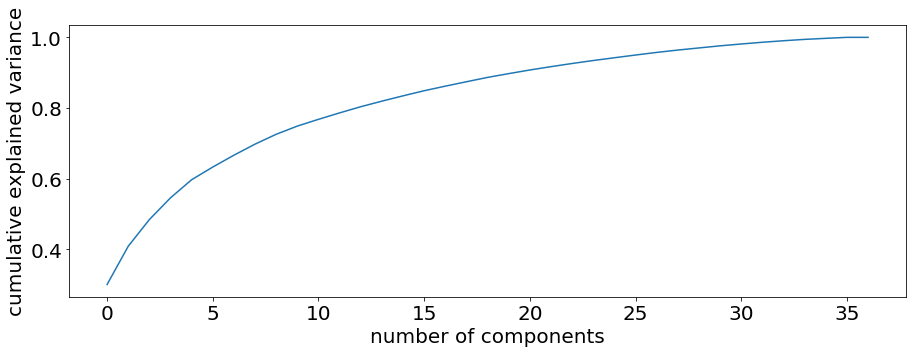

In [90]:
flat_samples = []
for action_sample in samples:
    flat_samples.append(action_sample.flatten().tolist())
#The function below converts flat_samples from a list to an array, and in the process adds zeros to make them equal length 
flat_samples = np.array(list(itertools.zip_longest(*flat_samples, fillvalue=0))).T

pca = PCA().fit(flat_samples)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Based on this graph, with 20 components, we can retain 90% of the variance.

In [62]:
pca = PCA(n_components=20)
data_after_pca = []

classifier = kNN() 

#parameters for ananlysis: the  distance function and number of neighbours checked for k-NN
distance_functions = ["euclidean", "dtw"]
number_of_neighbours_checked = [1,3,5]
parameters = [(dist_fun, nn) for dist_fun in distance_functions for nn in number_of_neighbours_checked]

results = np.empty((len(parameters), 2))

for i in range(len(parameters)):
    #apply 10-fold cross validation
    kf = KFold(n_splits=10, shuffle = True)
    kf.get_n_splits(labels)

    predictions = [] #probaility if each class label
    correct_labels = [] #actual labels
    perf_times = [] #time of completing the prediction

    for train_index, test_index in kf.split(labels):
        t0 = time.perf_counter()
        
        samples_train = flat_samples[train_index]
        pca.fit(samples_train) #gets principal components of the train samples
        data_after_pca = pca.transform(flat_samples) #and trasnsform the whole dataset with them
        samples_train, samples_test = data_after_pca[train_index], data_after_pca[test_index] 
        
        labels_train, labels_test = labels[train_index], labels[test_index]

        #training classifier
        classifier.fit(samples_train, labels_train) 
       
        #get predictions on test set
        prediction = classifier.predict(samples_test, distance_fun=parameters[i][0], k=parameters[i][1])
        
        perf_times.append(time.perf_counter()-t0)
        predictions.append(prediction)
        correct_labels = correct_labels + labels_test.tolist()
    
    predictions = pd.concat(predictions)
    #get accuarcy and brier score on the folded sets
    total_accuracy = accuracy(predictions, correct_labels)
    total_brier_score = brier_score(predictions, correct_labels)
    results[i] = total_accuracy, total_brier_score 
    
    #print average time
    print("%s distance, %dk completed in %.3f s"% (parameters[i][0], parameters[i][1], np.mean(perf_times)))
   

results = pd.DataFrame(results,index=pd.MultiIndex.from_product([distance_functions, number_of_neighbours_checked]),
                       columns=["Accuracy","Brier score"])

results

euclidean distance, 1k completed in 0.073 s
euclidean distance, 3k completed in 0.040 s
euclidean distance, 5k completed in 0.048 s
dtw distance, 1k completed in 0.246 s
dtw distance, 3k completed in 0.263 s
dtw distance, 5k completed in 0.309 s


Accuracy  Brier score
euclidean 1  0.891892     0.216216
          3  0.891892     0.210210
          5  0.891892     0.229189
dtw       1  0.837838     0.324324
          3  0.918919     0.210210
          5  0.783784     0.354595

# Applying PLS

In [77]:
counter = 0
for l in set(labels):
    labels[labels == l] = counter
    counter += 1
serialized_labels = labels.astype(int)
serialized_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [86]:
pls = PLSRegression(n_components=20)
data_after_pls = []

classifier = kNN() 

#parameters for ananlysis: the  distance function and number of neighbours checked for k-NN
distance_functions = ["euclidean", "dtw"]
number_of_neighbours_checked = [1,3,5]
parameters = [(dist_fun, nn) for dist_fun in distance_functions for nn in number_of_neighbours_checked]

results = np.empty((len(parameters), 2))

for i in range(len(parameters)):
    #apply 10-fold cross validation
    kf = KFold(n_splits=10, shuffle = True)
    kf.get_n_splits(serialized_labels)

    predictions = [] #probaility if each class label
    correct_labels = [] #actual labels
    perf_times = [] #time of completing the prediction

    for train_index, test_index in kf.split(labels):  
        t0 = time.perf_counter()
       
        samples_train = flat_samples[train_index]
        labels_train, labels_test = serialized_labels[train_index], serialized_labels[test_index]
        
        pls.fit(samples_train, labels_train) #gets PLS scores on training data
        data_after_pls = pls.transform(flat_samples) #and trasnsform the whole dataset with them
        samples_train, samples_test = data_after_pls[train_index], data_after_pls[test_index] 

        #training classifier
        classifier.fit(samples_train, labels_train) 
       
        #get predictions on test set
        prediction = classifier.predict(samples_test, distance_fun=parameters[i][0], k=parameters[i][1])
        
        perf_times.append(time.perf_counter()-t0)
        predictions.append(prediction)
        correct_labels = correct_labels + labels_test.tolist()
    
    predictions = pd.concat(predictions)
    #get accuarcy and brier score on the folded sets
    total_accuracy = accuracy(predictions, correct_labels)
    total_brier_score = brier_score(predictions, correct_labels)
    results[i] = total_accuracy, total_brier_score
    
    #print average time
    print("%s distance, %dk completed in %.3f s"% (parameters[i][0], parameters[i][1], np.mean(perf_times)))
   

results = pd.DataFrame(results,index=pd.MultiIndex.from_product([distance_functions, number_of_neighbours_checked]),
                       columns=["Accuracy","Brier score"])

results

euclidean distance, 1k completed in 0.027 s
euclidean distance, 3k completed in 0.029 s
euclidean distance, 5k completed in 0.027 s
dtw distance, 1k completed in 0.237 s
dtw distance, 3k completed in 0.216 s
dtw distance, 5k completed in 0.215 s


Accuracy  Brier score
euclidean 1  0.837838     0.324324
          3  0.864865     0.210210
          5  0.864865     0.218378
dtw       1  0.783784     0.432432
          3  0.837838     0.342342
          5  0.783784     0.395676